<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S8_9_retail_analytics/S09_Bass_Diffusion_Full_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S4 - Bass Diffusion - full demo

---

In session 2, we have defined the following two functions for Bass diffusion model:

<blockquote>
The cumulative number of adoptors (people who bought/adopted the product) $S(t)$ from the beginning (time 0) to time $t$ is described by $S(t) = m\times F(t)$ where $m$ is the market size (the estimated total number of potential customers) and $F(t)$ is the <i>cumulative</i> probability that an individual (potential customer) has already adopted the product by time $t$ (which needs to be calculated). 
We can obtain $F(t)$ as a function of $p$ and $q$ as follows:

$$F(t) = \frac{1-e^{-(p+q)t}}{1+\frac{q}{p}e^{-(p+q)t}} $$

where 
<br /> 
* $p$ is the coefficiant of innovation
<br /> 
* $q$ is the coefficient of imitation
<br /> 

In addition, the probability of adoption by an individual at time $t$ which is represented by $f(t)$ (recall that $f(t) = \frac{d}{dt}F(t)$) can be calculated as follows: 

$$f(t) = \frac{d}{dt}F(t) = \frac{e^{((p+q)t)}p(p+q)^2}{[pe^{((p+q)t)}+q]^2} $$.

Consequently, the estimated number of adoptions in each period can be calculated as  $s(t) = m\times f(t)$

</blockquote>

We have then prepared the following two functions to calculate $F(t)$ and $f(t)$.

In [2]:
import math
def Bass_cumulative_probability_Ft(p, q, t):
    return (1-math.exp(-(p+q)*t))/(1+(q/p)*math.exp(-(p+q)*t))

def Bass_probability_ft(p, q, t):
    return (math.exp((p+q)*t)*p*(p+q)**2)/(p*math.exp((p+q)*t)+q)**2

Based on the values of $p$, $q$ and $m$ of the quarterly sales of iPhone provided in the code cell below, please compute the values of the estimated probability of adoption $f(t)$, cumulative probability of adoption $F(t)$, the number of adoptions $s(t) = m\times f(t)$, and cumulative number of adoptions $S(t) = m\times F(t)$ for each quarter, which is indexed by $t$. Note that the first column below is an index whereas the subsequent four columns contain the corresponding values of the estimations based on Bass diffusion model.


|Quarter_Index| ft | Ft| st | St | 
| :- | :- | :- | :- | :- | 
|...| ... |...| ... |...|




### Regression for Bass parameters estimation (this is the additional part to the original notebook in S4)
**Estimating Bass diffussion model parameters**

We can now complete the Bass diffusion model pipeline by first estimating the parameters $p$, $q$ and $m$ from the data prior to performing prediction. First we load the modules which are required as well as the actual data of sales. The regression model for parameters estimation is presented in the paper below (Section "Discrete Analogue").

<b>Reference</b>: Bass, F. M. (1969). A new product growth for model consumer durables. Management science, 15(5), 215-227.


In [24]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import *

url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S04_Data_Structures_2/iphone_quarter_sales.csv'
actual_sales = pd.read_csv(url, index_col='Quarter')
actual_sales.head()

,Sales
Quarter,
0,0.270
1,1.119
2,2.315
3,1.703
4,0.717


We would need to determine the coefficient for the regression function. Here we will use the following equation (note that we do not shift one period like in the paper since the period is a bit long).

$S(T) = a + bY_{T} + cY^2_{T}$

In [64]:
input = pd.DataFrame()
# we need to prepare the Y inputs from sales by taking the cumulative sum up until period T - 1

input["sales"] = actual_sales["Sales"]
input["cumulative_sales"] = np.cumsum(actual_sales["Sales"])
input["cumulative_sales_sq"] = [x**2 for x in input["cumulative_sales"]]
input.head()

,sales,cumulative_sales,cumulative_sales_sq
Quarter,,,
0,0.270,0.270,7.290000e-02
1,1.119,1.389,1.929321e+00
2,2.315,3.704,1.371962e+01
3,1.703,5.407,2.923565e+01
4,0.717,6.124,3.750338e+01
5,6.892,13.016,1.694163e+02
6,4.363,17.379,3.020296e+02
7,3.793,21.172,4.482536e+02
8,5.208,26.380,6.959044e+02


Now we can use linear regression to determine $a$, $b$ and $c$ of the regression function above.

In [56]:
X = input[["cumulative_sales","cumulative_sales_sq"]]
y = input["sales"]
reg = sklearn.linear_model.LinearRegression().fit(X,y)
print("intercept: "+str(reg.intercept_))
print("coefficients: "+str(reg.coef_))

a = reg.intercept_
b = reg.coef_[0]
c = reg.coef_[1]

intercept: 4.708824765657091
coefficients: [ 1.24141130e-01 -7.31283416e-05]


Following the results, we can obtain

$m = \frac{-b \pm \sqrt{b^2-4ac}}{2c}$

and $m$ (the size of potential customer base) must be positive.

In [57]:
# determine m
m1 = (-b+math.sqrt(b**2-4*a*c))/(2*c)
m2 = (-b-math.sqrt(b**2-4*a*c))/(2*c)
m = max(m1,m2)
print("m1 = ", m1, ", m2 = ", m2, "m = ", m)

m1 =  -37.11955916309885 , m2 =  1734.6984659074083 m =  1734.6984659074083


Then, we can directly obtain $p = a/m$ and $q = -mc$ for the Bass diffusion model.

In [58]:
p = a/m
q = -m*c
print("m = ", m, ", p = ", p, "q = ", q)

m =  1734.6984659074083 , p =  0.0027144918025819196 q =  0.12685562199074296


### The following codes are from Session 4 (Bass diffustion prediction from the given parameters)

**Question 1**: Please compute the values as indicated in the table above for the first 40 quarters of the sales (i.e., 10 years) using the parameters provided. The index of the quarter must be from $0 \rightarrow 39$ (i.e., the first quarter is considered period $t=0$).

In [59]:
import pandas as pd
column_names = ['ft','Ft','st','St']
quarter_index = list(range(40))
bass_df = pd.DataFrame(index = quarter_index, columns = column_names)
bass_df.index.name = 'Quarter'

### start your code here ###
bass_df['ft'] = [Bass_probability_ft(p, q, t) for t in bass_df.index]
bass_df['Ft'] = [Bass_cumulative_probability_Ft(p, q, t) for t in bass_df.index]
bass_df['st'] = [m*bass_df.at[t,'ft'] for t in bass_df.index]
bass_df['St'] = [m*bass_df.at[t,'Ft'] for t in bass_df.index]
### end your code here ###

bass_df

,ft,Ft,st,St
Quarter,,,,
0,0.002714,0.000000,4.708825,0.000000
1,0.003072,0.002890,5.329303,5.012971
2,0.003474,0.006159,6.026836,10.684285
3,0.003926,0.009855,6.809655,17.095066
4,0.004431,0.014028,7.686484,24.334926
5,0.004996,0.018737,8.666458,32.502413
6,0.005626,0.024042,9.758980,41.705357
7,0.006326,0.030012,10.973539,52.061054
8,0.007102,0.036719,12.319449,63.696225



**Question 2**: Please (i) plot the columns `['ft','Ft']` in a single plot using line plot (parameter `kind='line'`) and (ii) plot the columns `['st','St']` in a single plot using bar plot (parameter `kind='bar'`). You can also indicate the plot size using the parameter `figsize = (12,4)`.

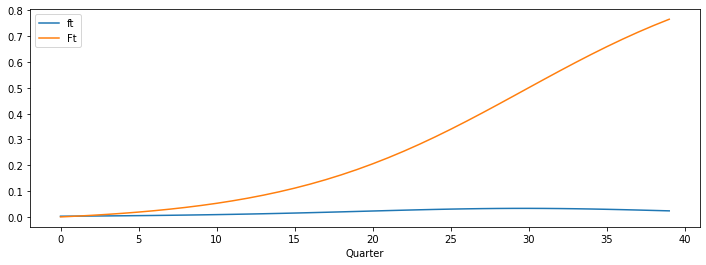

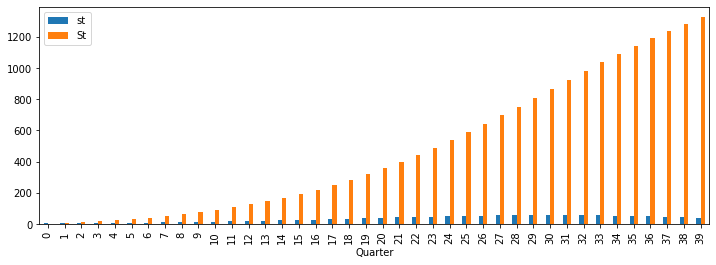

In [60]:
### start your code here ###
bass_df[['ft','Ft']].plot(figsize = (12,4))
bass_df[['st','St']].plot(kind = 'bar', figsize = (12,4))
### end your code here ###

Now we can compare the results with the actual quarterly sales of iPhone for the first 40 quarters (starting from Q2 2007 which the product was first introduced). 

**Question 3**: Please add the following columns and their corresponding values to the `bass_df` DataFrame


*   Column `'Actual'`: which contains the actual sales from the DataFrame `actual_sales`
*   Column `'CumulativeActual'`: which calculates the sum from the first quarter up until each quater in the index
*   Column `'PError'`: which calculates the percentage error of each corresponding quarter from column `'Actual'` and column `'st'` (estimated sales in each quarter), i.e., `PError = (Actual-st)/st`



In [61]:
### start your code here ###
bass_df['Actual'] = actual_sales['Sales']
bass_df['CumulativeActual'] = [sum(actual_sales.loc[:t,'Sales']) for t in actual_sales['Sales'].index]
bass_df['PError'] = (bass_df['Actual'] - bass_df['st'])/bass_df['Actual']
### end your code here ###
bass_df

,ft,Ft,st,St,Actual,CumulativeActual,PError
Quarter,,,,,,,
0,0.002714,0.000000,4.708825,0.000000,0.270,0.270,-16.440092
1,0.003072,0.002890,5.329303,5.012971,1.119,1.389,-3.762559
2,0.003474,0.006159,6.026836,10.684285,2.315,3.704,-1.603385
3,0.003926,0.009855,6.809655,17.095066,1.703,5.407,-2.998623
4,0.004431,0.014028,7.686484,24.334926,0.717,6.124,-9.720341
5,0.004996,0.018737,8.666458,32.502413,6.892,13.016,-0.257466
6,0.005626,0.024042,9.758980,41.705357,4.363,17.379,-1.236759
7,0.006326,0.030012,10.973539,52.061054,3.793,21.172,-1.893103
8,0.007102,0.036719,12.319449,63.696225,5.208,26.380,-1.365486


We can also generate the date of the last day of each quarter using the code below. This list will be later used as new indexes.

In [62]:
quarter_index_date = pd.date_range('4/1/2007', periods=40, freq='Q')
quarter_index_date


DatetimeIndex(['2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31',
               '2008-06-30', '2008-09-30', '2008-12-31', '2009-03-31',
               '2009-06-30', '2009-09-30', '2009-12-31', '2010-03-31',
               '2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31',
               '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31',
               '2012-06-30', '2012-09-30', '2012-12-31', '2013-03-31',
               '2013-06-30', '2013-09-30', '2013-12-31', '2014-03-31',
               '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31',
               '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31',
               '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

**Question 4**: Please (i) replace the original indexes using the newly created list `quarter_index_date` and (ii) then create the following plots from the DataFrame `bass_df` using the size `figsize=(12,4)`:


*   Columns `['St','CumulativeActual']` using a line plot
*   Columns `['st','Actual']` using a line plot
*   Column `['PError']` using a bar plot

**Hint**: you can use the method `.set_index(...)` by calling `bass_df =  bass_df.set_index(new_index_list, index_name)` to set the index (see [link](https://www.w3resource.com/pandas/dataframe/dataframe-set_index.php))



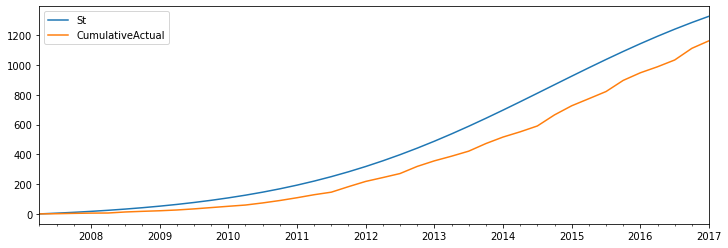

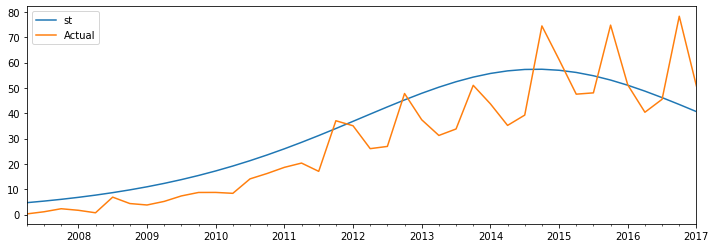

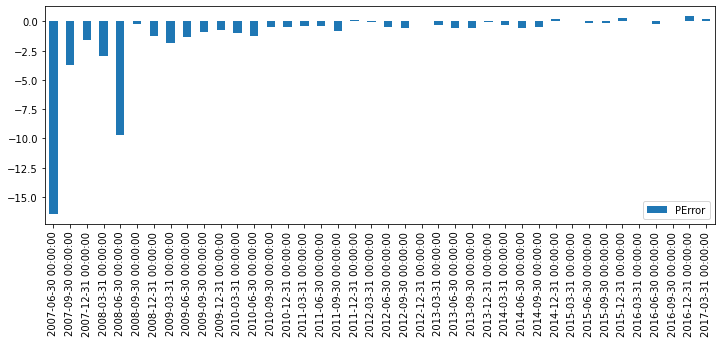

In [63]:
### start your code here ###
bass_df = bass_df.set_index(quarter_index_date, 'Quarter')
bass_df[['St','CumulativeActual']].plot(figsize=(12,4))
bass_df[['st','Actual']].plot(figsize=(12,4))
bass_df[['PError']].plot(kind='bar',figsize=(12,4))
### end your code here ###